In [1]:
part1_single_objects = "COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "COTSDataset/Part 3 - Complex Background"

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import SaRa.saraRC1 as sara

In [3]:
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_8_mask.png")
mask = cv2.imread(mask_path)

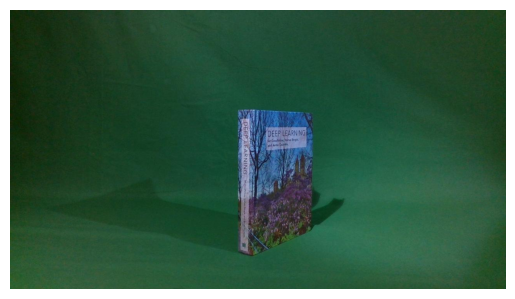

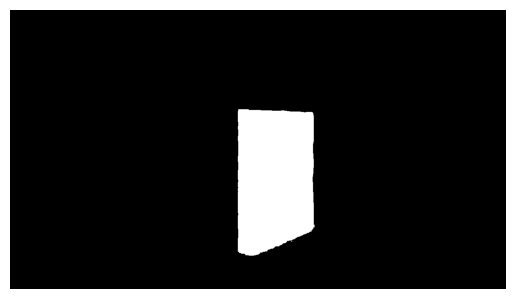

In [5]:
plot_img(img)
plot_img(mask)

In [6]:
def iou(image, mask):
    intersection = np.logical_and(image, mask)
    union = np.logical_or(image, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def f1_score(image, mask):
    intersection = np.logical_and(image, mask)
    precision = np.sum(intersection) / np.sum(image)
    recall = np.sum(intersection) / np.sum(mask)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [7]:
generator = 'itti'
GRID_SIZE =  7
sara.reset()
bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
sara_info = sara.return_sara(bgr_img, GRID_SIZE, generator)

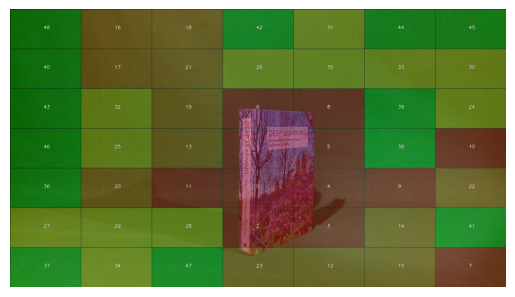

In [8]:
heatmap = cv2.cvtColor(sara_info[0], cv2.COLOR_BGR2RGB)
plot_img(heatmap)

In [9]:
# Creating a mask from the heatmap
# Rank, score, entropy, centre-bias, depth, index, quartile

# Changing info into a dictionary
sara_dict = {}
for info in sara_info[1]:
    rank, index, score, entropy, entropy_sum, centre_bias, depth, quartile = info
    sara_dict[rank] = {}
    sara_dict[rank]['score'] = score
    sara_dict[rank]['entropy'] = entropy
    sara_dict[rank]['entropy_sum'] = entropy_sum
    sara_dict[rank]['centre_bias'] = centre_bias
    sara_dict[rank]['depth'] = depth
    sara_dict[rank]['index'] = index
    sara_dict[rank]['quartile'] = quartile
    
    
# Sorting the dictionary by the scores key in the nested dictionary
sorted_sara_dict = {}
for key in sorted(sara_dict, key=lambda k: sara_dict[k]['score'], reverse=True):
    sorted_sara_dict[key] = sara_dict[key]

sorted_sara_dict

{31: {'score': 24.746927092012942,
  'entropy': 7.271787923078474,
  'entropy_sum': 1987691,
  'centre_bias': 1.9726549474122854,
  'depth': 1,
  'index': 0,
  'quartile': 1},
 24: {'score': 24.663987928250464,
  'entropy': 7.163262568015938,
  'entropy_sum': 1984198,
  'centre_bias': 2.0,
  'depth': 1,
  'index': 1,
  'quartile': 1},
 38: {'score': 24.427990090933264,
  'entropy': 7.095839266647717,
  'entropy_sum': 1861933,
  'centre_bias': 1.8950250709279723,
  'depth': 1,
  'index': 2,
  'quartile': 1},
 39: {'score': 24.173141647152015,
  'entropy': 6.706730486675826,
  'entropy_sum': 2182236,
  'centre_bias': 1.8705505632961241,
  'depth': 1,
  'index': 3,
  'quartile': 1},
 32: {'score': 24.065967472589403,
  'entropy': 6.8759431567192895,
  'entropy_sum': 1534886,
  'centre_bias': 1.946057646725596,
  'depth': 1,
  'index': 4,
  'quartile': 1},
 25: {'score': 23.777750388750068,
  'entropy': 6.70602604979992,
  'entropy_sum': 1327847,
  'centre_bias': 1.9726549474122854,
  'dep

In [10]:
def generate_segments(img, seg_count) -> list:
    '''
    Given an image img and the desired number of segments seg_count, this 
    function divides the image into segments and returns a list of segments.
    '''

    segments = {}
    segment_count = seg_count
    index = 0

    w_interval = int(img.shape[1] / segment_count)
    h_interval = int(img.shape[0] / segment_count)

    for i in range(segment_count):
        for j in range(segment_count):        
            
            coord_tup = (int(w_interval * j), int(h_interval * i),
                         int(w_interval * (j + 1)), int(h_interval * (i + 1)))
            segments[index] = coord_tup
            index += 1

    return segments

In [11]:
index_info = generate_segments(img, GRID_SIZE)

for rank in sorted_sara_dict:
    sorted_sara_dict[rank]['segment'] = index_info[rank]

In [12]:
# Taking the top 20 ranks and using them to create a mask
most_imp_ranks = np.zeros_like(img)

max_rank = int(GRID_SIZE*GRID_SIZE * 0.2)
count = 0
for rank in sorted_sara_dict.keys():
    if count <= max_rank:
        # Creating a mask based on the index and quartile
        index = rank
        
        coords = sorted_sara_dict[rank]['segment']
        x1, y1, x2, y2 = coords

        most_imp_ranks[y1:y2, x1:x2] = 255
    else:
        break
    count += 1

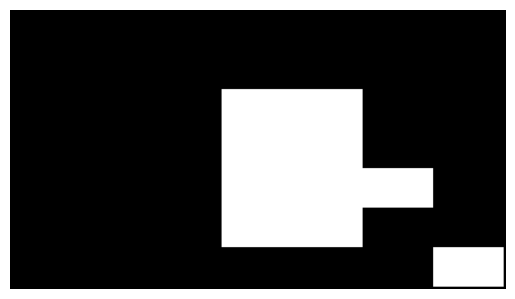

In [13]:
plot_img(most_imp_ranks)

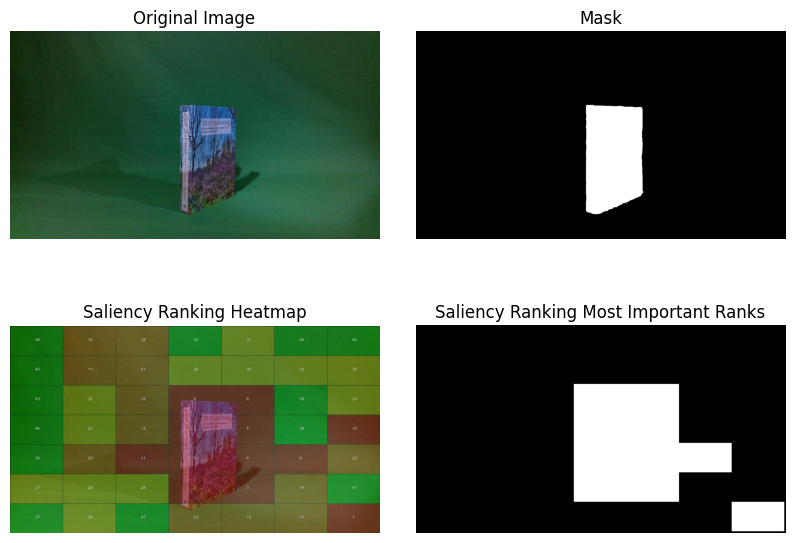

In [14]:
# Plotting in a 2 by 2 grid, the original img, mask, heatmap and the most important ranks
# Adjusting padding between the rows and columns
plt.rcParams['figure.subplot.wspace'] = 0.1

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0, 0].imshow(img)
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(mask)
ax[0, 1].axis('off')
ax[0, 1].set_title('Mask')

ax[1, 0].imshow(heatmap)
ax[1, 0].axis('off')
ax[1, 0].set_title('Saliency Ranking Heatmap')

ax[1, 1].imshow(most_imp_ranks)
ax[1, 1].axis('off')
ax[1, 1].set_title('Saliency Ranking Most Important Ranks')

plt.show()

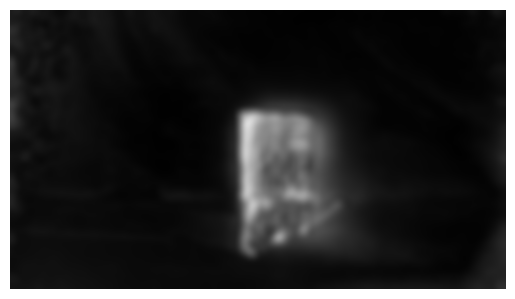

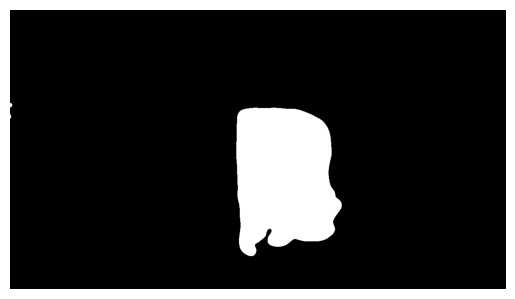

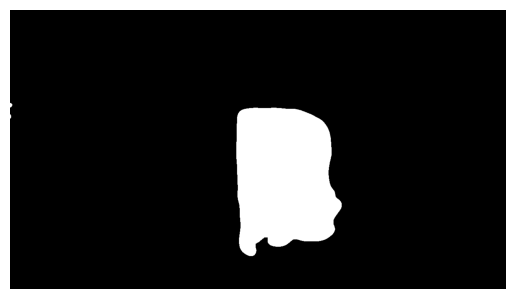

In [15]:
saliency_map_itti = sara.return_saliency(img.copy(), generator=generator)
saliency_map_rgb_itti = cv2.cvtColor(saliency_map_itti, cv2.COLOR_BGR2RGB)
saliency_map_gray_itti = cv2.cvtColor(saliency_map_rgb_itti, cv2.COLOR_RGB2GRAY)
plot_img(saliency_map_rgb_itti)


# Perform OTSU thresholding on the grayscale saliency map
ret, thresh_itti = cv2.threshold(saliency_map_gray_itti, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_img(thresh_itti)

# Performing morphological operations on the thresholded image
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(thresh_itti, kernel, iterations=2)
erosion = cv2.erode(dilated, kernel, iterations=2)
plot_img(erosion)


In [16]:
print("Itti saliency map")
iou_score = iou(saliency_map_rgb_itti, mask)
print("IOU score: ", iou_score)
weighted_iou_score = f1_score(saliency_map_rgb_itti, mask)
print("F1 Score: ", weighted_iou_score)
print()
print("Morphology on saliency map")
morphed_img = cv2.cvtColor(erosion, cv2.COLOR_GRAY2RGB)
iou_score = iou(morphed_img, mask)
print("IOU score: ", iou_score)
weighted_iou_score = f1_score(morphed_img, mask)
print("F1 Score: ", weighted_iou_score)

Itti saliency map
IOU score:  0.07369683159722222
F1 Score:  0.0036883074723076227

Morphology on saliency map
IOU score:  0.7700147261634838
F1 Score:  0.0034120231297093406


c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  w

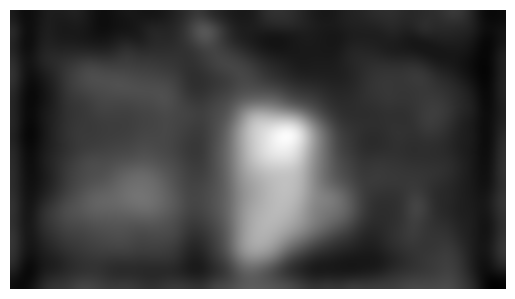

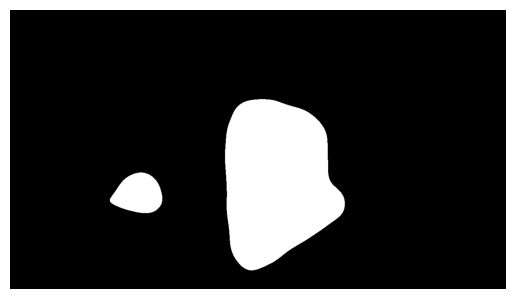

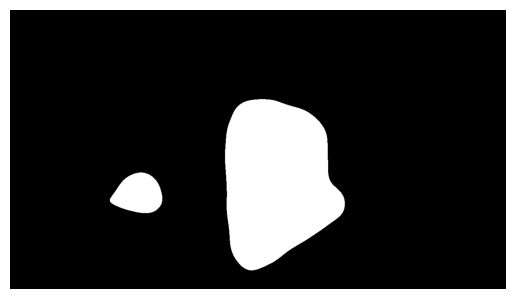

In [17]:
generator = 'deepgaze'
saliency_map_deepgaze = sara.return_saliency(img.copy(), generator=generator)
saliency_map_rgb_deepgaze = cv2.cvtColor(saliency_map_deepgaze, cv2.COLOR_BGR2RGB)
saliency_map_gray_deepgaze = cv2.cvtColor(saliency_map_rgb_deepgaze, cv2.COLOR_RGB2GRAY)
plot_img(saliency_map_rgb_deepgaze)


# Perform OTSU thresholding on the grayscale saliency map
ret, thresh_deepgaze = cv2.threshold(saliency_map_gray_deepgaze, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_img(thresh_deepgaze)

# Performing morphological operations on the thresholded image
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(thresh_deepgaze, kernel, iterations=2)
erosion = cv2.erode(dilated, kernel, iterations=2)
plot_img(erosion)


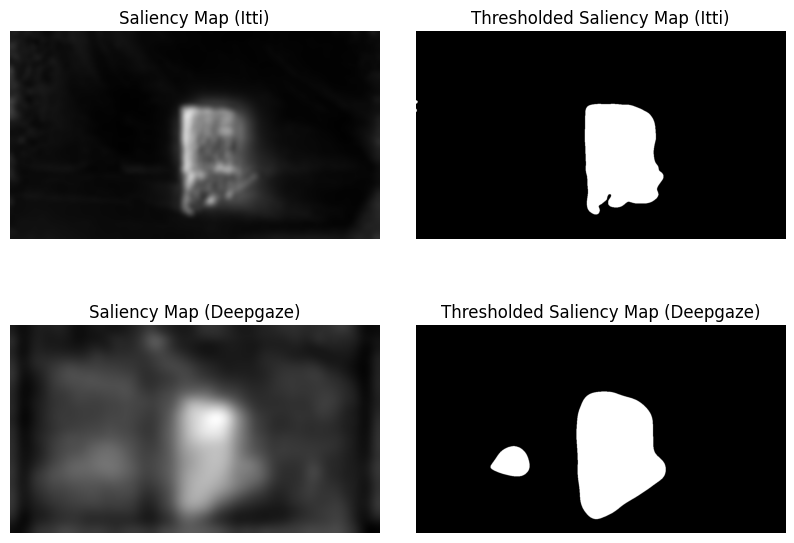

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0, 0].imshow(saliency_map_rgb_itti)
ax[0, 0].axis('off')
ax[0, 0].set_title("Saliency Map (Itti)")
ax[0, 1].imshow(thresh_itti, cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title("Thresholded Saliency Map (Itti)")
ax[1, 0].imshow(saliency_map_rgb_deepgaze)
ax[1, 0].axis('off')
ax[1, 0].set_title("Saliency Map (Deepgaze)")
ax[1, 1].imshow(thresh_deepgaze, cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title("Thresholded Saliency Map (Deepgaze)")
plt.show()

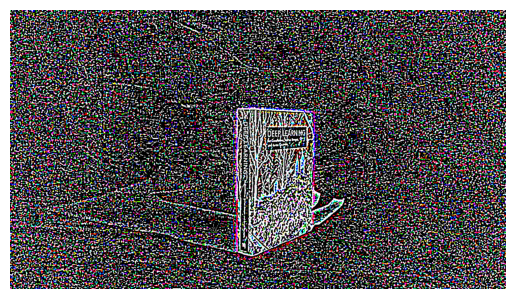

In [19]:
# Applying difference of gaussian to the image
# Define the standard deviations for the two Gaussian blurs
sigma1 = 1.0  # Adjust as needed
sigma2 = 2.0  # Adjust as needed

# Apply Gaussian blur with sigma1
blur1 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma1)

# Apply Gaussian blur with sigma2
blur2 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma2)

# Compute the difference of Gaussian (DoG)
DoG = blur1 - blur2
plot_img(DoG)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


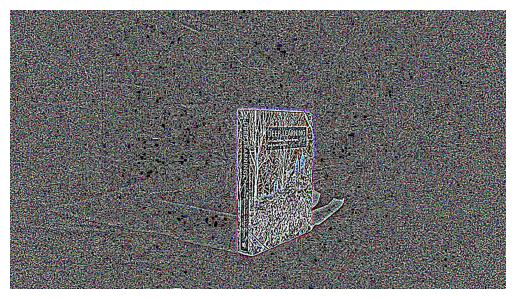

In [20]:
# Applying Laplacian of Gaussian to the image
# Define the standard deviation for the Gaussian blur
sigma = 1.0  # Adjust as needed

# Apply Gaussian blur with the specified sigma
blurred_img = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma)

# Apply the Laplacian operator to the blurred image
LoG = cv2.Laplacian(blurred_img, cv2.CV_64F)
plot_img(LoG)

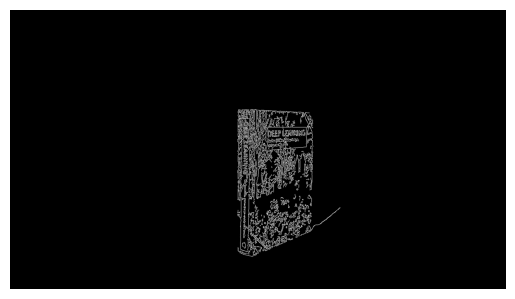

In [21]:
# Applying Canny edge detection to the image
# Apply Canny edge detector
canny = cv2.Canny(img, threshold1=100, threshold2=200)  # Adjust thresholds as needed
plot_img(canny)

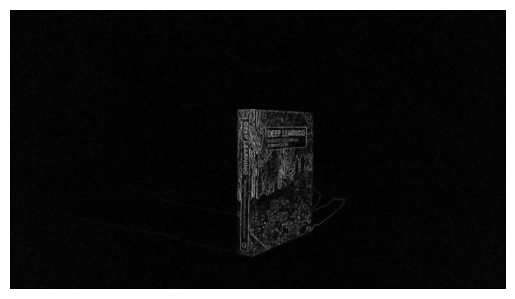

In [22]:
# Applying edge detection with Sobel Kernel
gray_scale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Apply Sobel filter for x-direction (horizontal edges)
sobel_x = cv2.Sobel(gray_scale_img, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter for y-direction (vertical edges)
sobel_y = cv2.Sobel(gray_scale_img, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the magnitude of the gradient
gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

plot_img(gradient_magnitude)

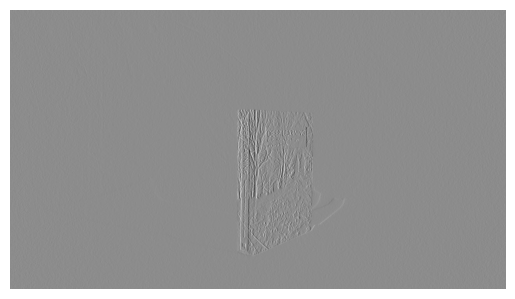

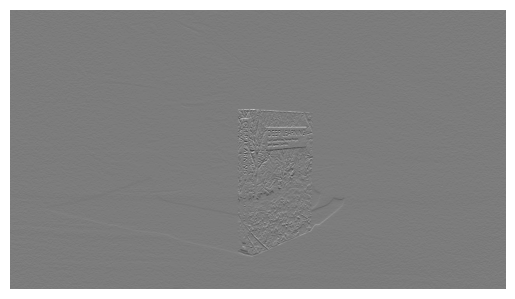

In [23]:
# Apply Sobel filter for x-direction (horizontal edges)
sobel_x = cv2.Sobel(gray_scale_img, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel filter for y-direction (vertical edges)
sobel_y = cv2.Sobel(gray_scale_img, cv2.CV_64F, 0, 1, ksize=3)

plot_img(sobel_x)
plot_img(sobel_y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


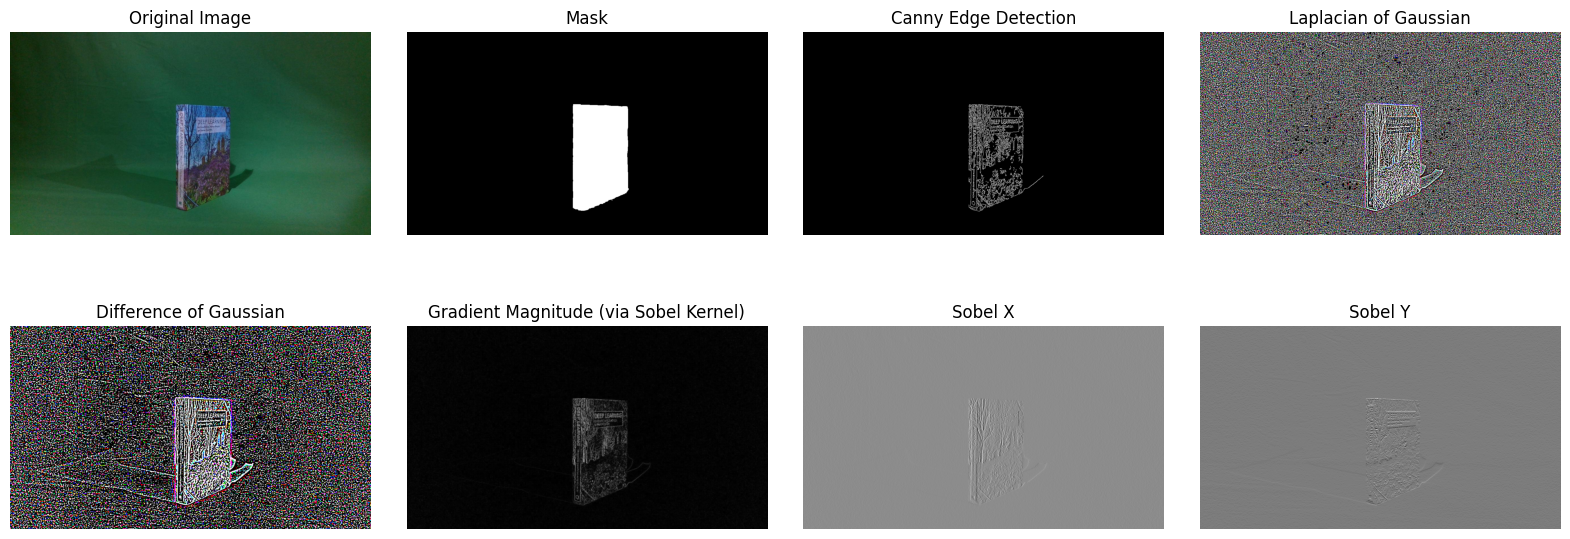

In [24]:
# Plotting all the edge detections together
fig, ax = plt.subplots(2, 4, figsize=(20, 7))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title("Mask")
ax[0, 2].imshow(canny, cmap='gray')
ax[0, 2].axis('off')
ax[0, 2].set_title("Canny Edge Detection")
ax[0, 3].imshow(LoG, cmap='gray')
ax[0, 3].axis('off')
ax[0, 3].set_title("Laplacian of Gaussian")
ax[1, 0].imshow(DoG)
ax[1, 0].axis('off')
ax[1, 0].set_title("Difference of Gaussian")
ax[1, 1].imshow(gradient_magnitude, cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title("Gradient Magnitude (via Sobel Kernel)")
ax[1, 2].imshow(sobel_x, cmap='gray')
ax[1, 2].axis('off')
ax[1, 2].set_title("Sobel X")
ax[1, 3].imshow(sobel_y, cmap='gray')
ax[1, 3].axis('off')
ax[1, 3].set_title("Sobel Y")
plt.show()


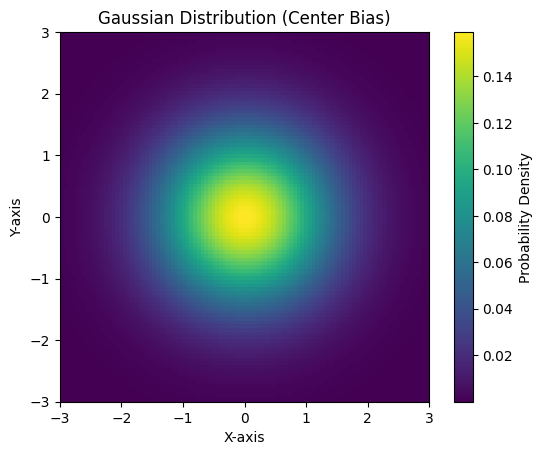

In [25]:
# Create a grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
x, y = np.meshgrid(x, y)

# Calculate the Gaussian distribution values at each point on the grid
mean = [0, 0]  # Mean of the Gaussian distribution
cov = [[1, 0], [0, 1]]  # Covariance matrix
z = np.exp(-0.5 * (x**2 + y**2))
z /= (2 * np.pi * np.sqrt(np.linalg.det(cov)))

# Create a heatmap
plt.imshow(z, extent=[-3, 3, -3, 3], cmap='viridis', origin='lower')
plt.colorbar(label='Probability Density')
plt.title('Gaussian Distribution (Center Bias)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()

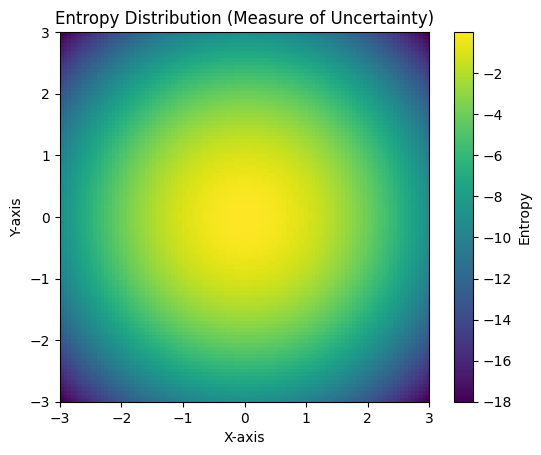

In [26]:
# Create a grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
x, y = np.meshgrid(x, y)

# Calculate the entropy values at each point on the grid
entropy = -x**2 - y**2  # Replace this with your own entropy calculation

# Create a heatmap
plt.imshow(entropy, extent=[-3, 3, -3, 3], cmap='viridis', origin='lower')
plt.colorbar(label='Entropy')
plt.title('Entropy Distribution (Measure of Uncertainty)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.show()

# GradCam

In [27]:
from torchvision import models
import numpy as np
import cv2
import PIL

In [28]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [29]:

model = models.resnet50(pretrained=True)
model.eval()

c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\ComputerVision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

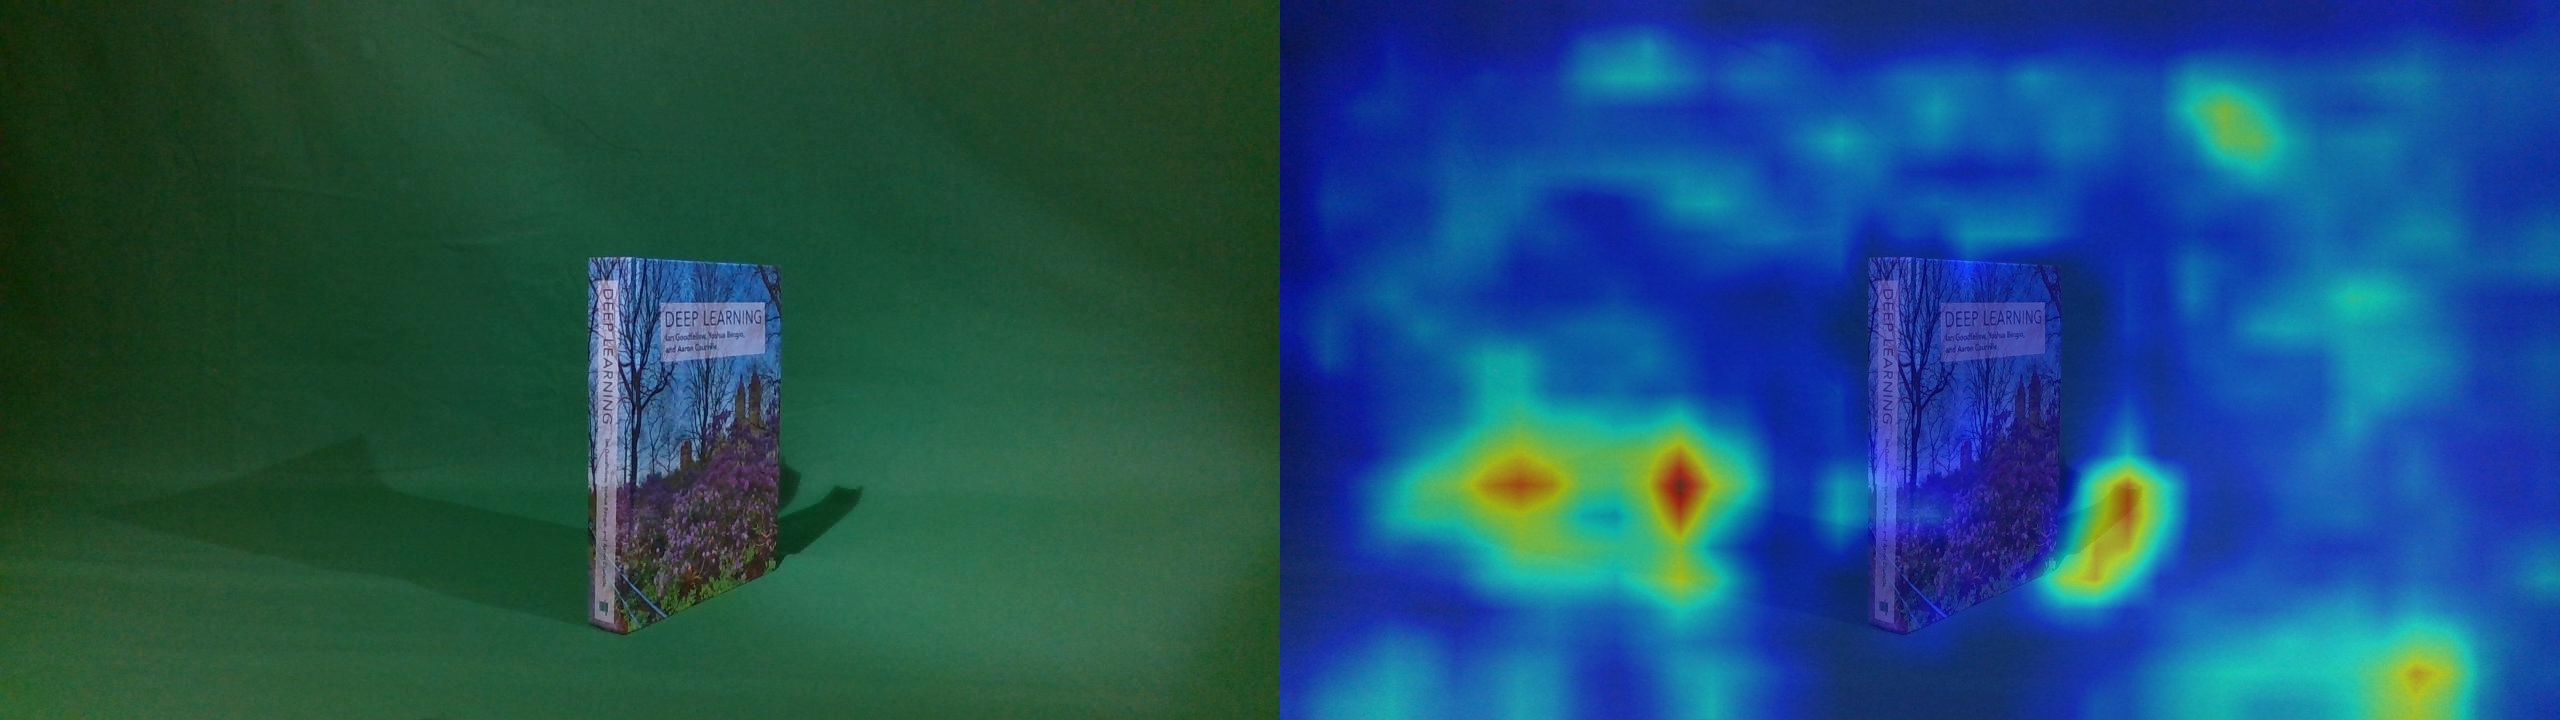

In [30]:

# fix target class label (of the Imagenet class of interest!)
# 1: goldfish, 250: Siberian Husky, 947: mushroom

targets = [ClassifierOutputTarget(1)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers)
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers) # use this for Grad-CAM++

# Preprocess input image, get the input image tensor

new_img = img.copy()
new_img = np.float32(new_img) / 255
input_tensor = preprocess_image(new_img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(new_img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])

# display the original image & the associated CAM
images = np.hstack((np.uint8(255*new_img), cam_image))
PIL.Image.fromarray(images)

# RL Gym Environment

In [31]:
# !pip install gymnasium

In [32]:
from custom_env import ImageSegmentationEnv

In [33]:
# # RL Gym loop
# # Instantiate the environment
# env = ImageSegmentationEnv(saliency_map_gray_itti, mask)

# # Reset the environment
# env.reset()

# # Run the environment for 100 steps
# for i in range(2):
#     action = env.action_space.sample()
#     observation, reward, truncated, terminated, info = env.step(action)
#     env.render(mode='image')
#     if truncated:
#         break

# # Close the environment
# env.close()


In [34]:
env = ImageSegmentationEnv(img, mask)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Access the initial observation (grayscale image) by resetting the environment
initial_observation = env.reset()

# Access the observation after taking an action
action = 1  # Example action
new_observation, reward, truncated, terminated, _ = env.step(action)

# Process or visualize the observation
# For example, you can display the initial observation using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(initial_observation, cmap='gray')
plt.axis('off')
plt.title("Initial Observation")
plt.show()

error: OpenCV(4.8.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0xa7e5ea26::Set<3,4,-1>,struct cv::impl::A0xa7e5ea26::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import torchvision

# Feature extraction using VGG-16
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg16 = torchvision.models.vgg16(pretrained=True)
        vgg16.eval()  # To disable dropout
        self.features = list(vgg16.children())[0]

    def forward(self, x):
        x = self.features(x)
        return x

# DQN Architecture
class DQN(nn.Module):
    def __init__(self, input_size, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1024)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1024, num_actions)  # The output layer now has 'num_actions' units.

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  # Output Q-values for each action.
        return x

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# Define hyperparameters
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate
learning_rate = 0.001
batch_size = 32
target_update = 10

# Initialize environment-specific variables
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 10

# Create the DQN and target DQN models
input_size = saliency_map_gray_itti.shape[1]  # Define the input size
output_size = action_size  # Define the output size
dqn = DQN(input_size, output_size)
target_dqn = DQN(input_size, output_size)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

# Define the optimizer
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)

# Create the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = dqn(torch.FloatTensor(state))
                action = torch.argmax(q_values).item()

        next_state, reward, truncated, terminated, info = env.step(action)
        done = truncated or terminated
        total_reward += reward

        replay_buffer.push(state, action, reward, next_state, done)

        if len(replay_buffer.memory) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.BoolTensor(dones)

            q_values = dqn(states)
            next_q_values = target_dqn(next_states)
            actions = actions.view(-1, 1).to(torch.int64)  
            q_values = q_values.to(torch.float32)  
            print(actions.shape)
            print(q_values.shape)
            print(actions.dtype)
            print(q_values.dtype)

            q_value = q_values.gather(1, actions).squeeze(1)


            next_q_value = next_q_values.max(1).values
            expected_q_value = rewards + gamma * next_q_value * ~dones
            loss = torch.nn.functional.smooth_l1_loss(q_value, expected_q_value)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_update == 0:
        target_dqn.load_state_dict(dqn.state_dict())

    print(f"Episode: {episode}, Total Reward: {total_reward}")

# Test the trained DQN agent
# Implement code to run the trained DQN agent and visualize bounding box refinement

# Save the trained model
torch.save(dqn.state_dict(), 'dqn_bounding_box_refinement.pth')


torch.Size([32, 1])
torch.Size([32, 720, 9])
torch.int64
torch.float32


RuntimeError: Index tensor must have the same number of dimensions as input tensor